In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from fastai.basic_data import *
from fastai.basic_train import Learner
from fastai.train import fit_one_cycle

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


In [2]:
%%time
df = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 2min 24s, sys: 9.66 s, total: 2min 34s
Wall time: 2min 34s


In [3]:
print(df.shape)
df.head()

(629145480, 2)


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


### Modeling - Recurrent Neural Network 

In [4]:
class RnnBasedLAN(nn.Module):
    def __init__(self, D_in, H, layers=3, dropout=0.2, bidirectional=False):
        super(RnnBasedLAN, self).__init__()
        self.rnn = torch.nn.LSTM(
            D_in,
            H,
            num_layers=layers,
            batch_first=True,
            dropout=dropout,
        )
        self.norm = nn.LayerNorm(H)
        self.conv = nn.Conv2d(H, 1, 1)
        
    def forward(self, x):
        """x.shape = (batch_size, seq_len, features)"""
        x, (h_n, c_n) = self.rnn(x)
        x = self.norm(x)
        x = x.transpose(1,2)
        return self.conv(x[:,:,:,None]).squeeze()
    
def test_rnn():
    x = torch.rand(32,150,12)
    mdl = RnnBasedLAN(12,16)
    print(mdl(x).shape)
test_rnn()

torch.Size([32, 150])


### Feature Extraction

In [16]:
def extract_features(z):
    array = [z.mean(axis=1), z.min(axis=1), z.max(axis=1), z.std(axis=1), z.sum(axis=1), [len(z[i,np.abs(z[i,:]) > 500]) for i in range(z.shape[0])], 
             z.max(axis=1) - np.abs(z.min(axis=1)), np.quantile(z, 0.05,axis=1), ]
    return np.c_[array].T.astype(np.float32)

extract_features(np.random.rand(150,100))

# For a given ending position "last_index", we split the last 150'000 values 
# of "x" into 150 pieces of length 1000 each. So n_steps * step_length should equal 150'000.
# From each piece, a set features are extracted. This results in a feature matrix 
# of dimension (150 time steps x features).  
def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
       
    assert (last_index - (n_steps * step_length)) >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also of the last 10 observations. 
    return np.c_[extract_features(temp),
                 extract_features(temp[:, -step_length // 10:]),
                 extract_features(temp[:, -step_length // 100:])].astype(np.float32)

# Query "create_X" to figure out the number of features
n_features = create_X(df.values, n_steps=10).shape[1]
print("This RNN model is based on %i features"% n_features)

This RNN model is based on 24 features


In [6]:
class LANL_Dataset(Dataset):
    def __init__(
        self,
        df,
        seq_len=150,
        rand=False
    ):
        self.x =  df.loc[:,'acoustic_data'].values
        self.y = df.loc[:,'time_to_failure'].values
        self.seq_len = seq_len
        self.rand = rand
        
    def __len__(self):
        return int(self.x.shape[0]/1000/self.seq_len)-1
        

    def __getitem__(self, idx):
        idx +=1
        idx *= 150*1000
        if self.rand:
            idx += int(np.random.randn()*999)
        sample = {
            "x": create_X(self.x, last_index=idx, n_steps=self.seq_len, step_length=1000),
            "y": self.y[np.arange(idx - self.seq_len*1000,idx,1000)],
        }
        

        return sample['x'],sample['y'].astype(np.float32)
    
ds = LANL_Dataset(df)
for i in tqdm(range(len(ds))):
    dct = [o.shape for o in ds[i]]
print(dct)

100%|██████████| 4193/4193 [00:30<00:00, 137.98it/s]

[(150, 24), (150,)]


In [7]:
idx = 150*1000*64
print(idx- 150*1000,idx)
np.arange(idx - 150*1000,idx,1000).shape

9450000 9600000


(150,)

[1.4691   1.469099 1.469098 1.469097 ... 1.431897 1.431896 1.430799 1.430798]


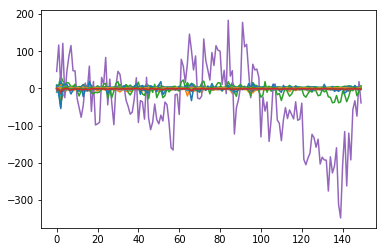

11.455599


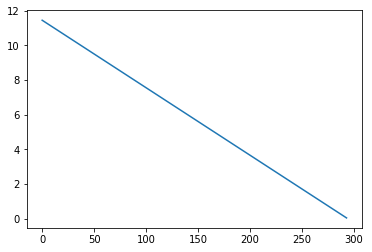

In [8]:
def plot_sample(sample):    
    plt.plot(sample[0])
    print(sample[1])
    plt.show()
plot_sample(ds[0])
second_earthquake = 50085877
valid_ds = LANL_Dataset(df.iloc[second_earthquake-150*1000*295:second_earthquake,:])
result = []
for i in range(len(valid_ds)):
    result.append(valid_ds[i][1][-1])
print(result[0])
plt.figure()
plt.plot(result)

In [9]:
# between train and validation
second_earthquake = 50085877

train_dl = DataLoader(LANL_Dataset(df.iloc[:-150*1000*65,:],rand = True), batch_size= 64, num_workers=4)
valid_dl = DataLoader(LANL_Dataset(df.iloc[second_earthquake-150*1000*295:second_earthquake,:]), batch_size= 32, num_workers=2)

loss = torch.nn.MSELoss()

In [10]:
def last_step_acc(preds, targs):
    return torch.mean(torch.abs( preds[:,-1]-targs[:,-1]))

In [11]:
data_bunch = DataBunch(train_dl, valid_dl)

In [14]:
learn = Learner(data_bunch, RnnBasedLAN(24,32), loss_func=loss, metrics = [last_step_acc])

In [17]:
learn.fit_one_cycle(10,0.01)

epoch,train_loss,valid_loss,last_step_acc,time
0,20.881771,12.968961,3.034344,00:28
1,15.265742,10.961390,2.865591,00:28
2,14.109701,10.958992,2.865404,00:28
3,13.772815,10.971591,2.866372,00:28
4,13.581934,10.998455,2.868544,00:28
5,13.392735,11.033129,2.871367,00:28
6,13.217958,11.024844,2.870709,00:28
7,13.088071,10.977448,2.866878,00:28
8,12.995005,10.962824,2.865670,00:28
9,12.946448,10.960144,2.865439,00:28


In [18]:
learn.validate()

[10.960144, tensor(2.8654)]

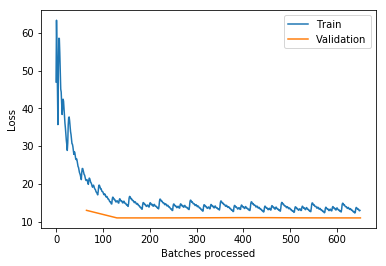

In [19]:
learn.recorder.plot_losses()

In [20]:
mdl = learn.model

In [21]:
# Prepare submission
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    x = torch.tensor(create_X(x))[None,:,:].to(torch.device('cuda'))
    pred = mdl(x).cpu().detach().numpy()[0]
    submission.time_to_failure[i] = pred


  1%|          | 27/2624 [00:19<01:19, 32.66it/s]Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f77750ede10>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/opt/conda/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 
100%|██████████| 2624/2624 [15:26<00:00, 33.09it/s]   


In [22]:
submission.to_csv('submission.csv')

In [23]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,5.579088
seg_0012b5,5.594763
seg_00184e,5.594742
seg_003339,5.594794
seg_0042cc,5.592702
